# Сравнение методов классификации на реальных наборах данных

Для раскрытия данной темы был взят датасет с сайта kaggle\
https://www.kaggle.com/datasets/d4rklucif3r/cat-and-dogs

### Задача

Определить, что находится на картинке, собака или кошка.

### О наборе данных
Этот набор данных содержит 3 файла:
1) Набор для обучения: Обучающие изображения кошек и собак \
2) Тестовый набор: Тестовые изображения кошек и собак\
3) Одиночные прогнозы: Каталог для одиночных прогнозов изображений\

В нем находятся 10000 изображений кошек и собак, изначально разбитых на обучающую и тестовую выборку в соотноешении 80/20. Также надо сказать, что датасет "качественный" в том смысле, что все картинки читаются и нет необходимости производить предобработку.

# Начало работы

### Импортируем библиотеки

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import  Dense,Conv2D,MaxPooling2D,Dropout,Activation
from tensorflow.keras import backend as bk
from tqdm import tqdm
import cv2
from PIL import Image
from tensorflow.keras.optimizers import SGD,Adam,RMSprop,Adagrad,Adamax
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.metrics import classification_report

Сразу отбросим нежелательные сообщения, не влияющие на работу

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# from sklearn.utils import shuffle
from PIL import Image

In [ ]:
class_name=["cats","dogs"]
label_name={class_name: i for i, class_name in enumerate(class_name)}

In [ ]:
print(len(label_name))

2


Смотрим на случайные картинки из датасета

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

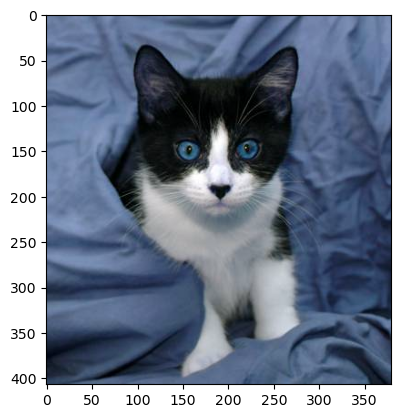

In [ ]:
image_path=cv2.imread("./dataset/training_set/cats/cat.1002.jpg")
plt.imshow(image_path)
plt.show()

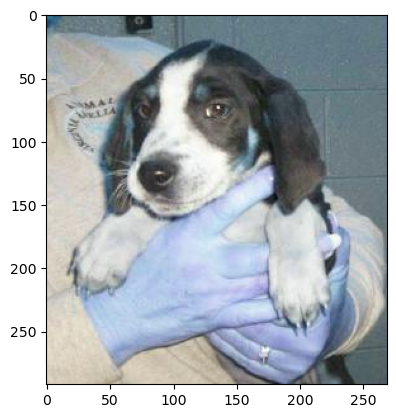

In [ ]:
image_path=cv2.imread("./dataset/training_set/dogs/dog.10.jpg")
plt.imshow(image_path)
plt.show()

In [ ]:
image_shape=(128,128)

### Загружаем датасет

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def data_set_load():

    # Сначала создаются два списка путей к данным
    data_path=["./dataset/training_set/","./dataset/test_set/"]

    # Далее создается пустой список, в который будут добавляться данные в процессе их загрузки
    image_data_output=[]
    for i in data_path:
        # создается пустой список
        image_data=[]
        label_data=[]
        print("Counting:{}".format(i))

        for j in os.listdir(i):
            label=label_name[j]
            for image_data_file in tqdm(os.listdir(os.path.join(i,j))):
                # получаем путь к изображению
                image_path=os.path.join(os.path.join(i,j),image_data_file)
                # считываем
                image=cv2.imread(image_path)
                # изображение преобразуется из цветовой модели BGR в RGB
                image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                # изображение изменяется в размере
                image=cv2.resize(image,image_shape)
                # измененное изображение добавляется в список
                image_data.append(image)
                # метка класса добавляется в список
                label_data.append(label)

        image_data=np.array(image_data,dtype="float32")
        label_data=np.array(label_data,dtype="float32")
        image_data_output.append((image_data,label_data))
    # После прохода по всем папкам из списка data_path, список image_data_output
    # содержит два кортежа с данными для обучения и тестирования модели

    return image_data_output

In [ ]:
data_set_load()

Counting:./dataset/training_set/


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:12<00:00, 316.66it/s]


Counting:./dataset/test_set/


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.22it/s]


[(array([[[[ 40.,  44.,  41.],
           [ 41.,  45.,  44.],
           [ 41.,  44.,  49.],
           ...,
           [165., 166., 155.],
           [208., 205., 180.],
           [200., 196., 163.]],
  
          [[ 39.,  44.,  39.],
           [ 38.,  42.,  41.],
           [ 37.,  41.,  45.],
           ...,
           [160., 160., 150.],
           [196., 191., 169.],
           [202., 196., 166.]],
  
          [[ 37.,  42.,  38.],
           [ 33.,  37.,  36.],
           [ 32.,  36.,  40.],
           ...,
           [161., 159., 153.],
           [190., 183., 164.],
           [201., 194., 166.]],
  
          ...,
  
          [[ 22.,  20.,  21.],
           [ 19.,  17.,  18.],
           [ 19.,  17.,  18.],
           ...,
           [ 55.,  39.,  35.],
           [ 84.,  71.,  65.],
           [ 36.,  25.,  19.]],
  
          [[ 28.,  26.,  27.],
           [ 22.,  20.,  21.],
           [ 22.,  20.,  21.],
           ...,
           [ 51.,  35.,  30.],
           [ 47., 

In [ ]:
(X_train,Y_train),(X_test,Y_test)=data_set_load()

Counting:./dataset/training_set/


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:10<00:00, 371.14it/s]


Counting:./dataset/test_set/


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 420.30it/s]


In [ ]:
_,train_image_label_info=np.unique(Y_train,return_counts=True)
_,test_image_label_info=np.unique(Y_test,return_counts=True)

In [ ]:
print("Train image label information for 0 class  :",train_image_label_info[0])
print("Train image label information for 1 class  :",train_image_label_info[1])

Train image label information for 0 class  : 4000
Train image label information for 1 class  : 4000


In [ ]:
print("Test image label information for 0 class  :",test_image_label_info[0])
print("Test image label information for 1 class  :",test_image_label_info[1])

Test image label information for 0 class  : 1000
Test image label information for 1 class  : 1000


### Создаем фрейм данных для метки изображения и смотрим на разбиение тестовой и обучающей выборки

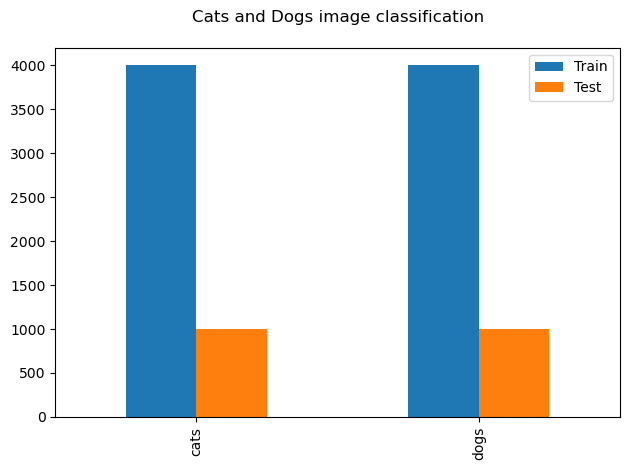

In [ ]:
pd.DataFrame({"Train":train_image_label_info,"Test":test_image_label_info},index=class_name).plot.bar()
plt.title("Cats and Dogs image classification\n")
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
x=pd.DataFrame({"Train":train_image_label_info,"Test":test_image_label_info},index=class_name)
print(x)

      Train  Test
cats   4000  1000
dogs   4000  1000


В датафрейме выше наглядно видно соотношение тестовой и обучающей выборки. Также можно заметить, что оба класса сбалансированы и имеют одинаковое количество объектов

In [ ]:
y=(x["Train"][0],x["Train"][1],x["Test"][0],x["Test"][1])
myexplode = [0.2, 0,0.2,0.3]

In [ ]:
my_label=["Cat image_Train ","Dog image_Train","Cat image_Test","Dog image_Test"]
color = ['#FA8F0A','#F0DA32','slateblue','#61F527','#18DE9D']

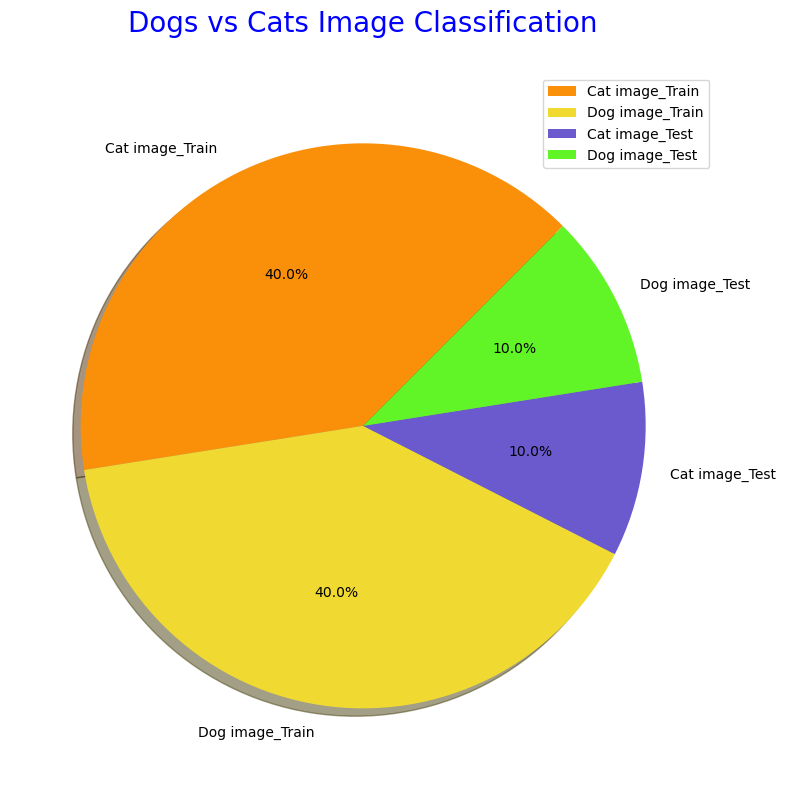

In [ ]:
plt.figure(figsize=(8,8))
plt.pie(y, labels =my_label, shadow = True,colors=color,autopct='%1.1f%%',startangle=45,counterclock=True)
plt.title("Dogs vs Cats Image Classification\n",color="Blue",fontsize=20)
plt.tight_layout()
plt.legend(loc="best")
plt.show()

### Числовые параметры выборок

Количество уникальных элементов

In [ ]:
len(np.unique(X_train[0]))

216

In [ ]:
len(np.unique(X_test[0]))

256

In [ ]:
X_train

array([[[[ 40.,  44.,  41.],
         [ 41.,  45.,  44.],
         [ 41.,  44.,  49.],
         ...,
         [165., 166., 155.],
         [208., 205., 180.],
         [200., 196., 163.]],

        [[ 39.,  44.,  39.],
         [ 38.,  42.,  41.],
         [ 37.,  41.,  45.],
         ...,
         [160., 160., 150.],
         [196., 191., 169.],
         [202., 196., 166.]],

        [[ 37.,  42.,  38.],
         [ 33.,  37.,  36.],
         [ 32.,  36.,  40.],
         ...,
         [161., 159., 153.],
         [190., 183., 164.],
         [201., 194., 166.]],

        ...,

        [[ 22.,  20.,  21.],
         [ 19.,  17.,  18.],
         [ 19.,  17.,  18.],
         ...,
         [ 55.,  39.,  35.],
         [ 84.,  71.,  65.],
         [ 36.,  25.,  19.]],

        [[ 28.,  26.,  27.],
         [ 22.,  20.,  21.],
         [ 22.,  20.,  21.],
         ...,
         [ 51.,  35.,  30.],
         [ 47.,  34.,  28.],
         [ 43.,  31.,  25.]],

        [[ 30.,  28.,  29.],
       

In [ ]:
train_image=X_train/255.0
len(np.unique(train_image[0]))

216

In [ ]:
test_image=X_test/255.0
len(np.unique(test_image[0]))

256

### Визуализация случайных изображений кошек и собак

In [ ]:
def RandomImage_visualization(class_names,imagedata_path,imagedata_label):
    # Создание новой фигуры для визуализации изображений
    fig=plt.figure(figsize=(10,10))
    # Заголовок для фигуры
    fig.suptitle("Визуализация изображений с котами и собаками\n",color="blue",fontsize=20)

    # Отображение 9 изображений на фигуре
    for i in range(9):
        plt.subplot(3,3,i+1)
        # Установка пустых меток на осях координат
        plt.xticks([])
        plt.yticks([])
        # Установка плотного расположения изображений
        plt.tight_layout()
        # Отображение текущего изображения
        plt.imshow(imagedata_path[i],cmap=plt.cm.BrBG)
        # Установка метки с названием соответствующего класса для текущего изображения
        plt.xlabel("Имя класса: {}".format(class_names[int(imagedata_label[i])]))
    # Отображение фигуры с изображениями
    plt.show()

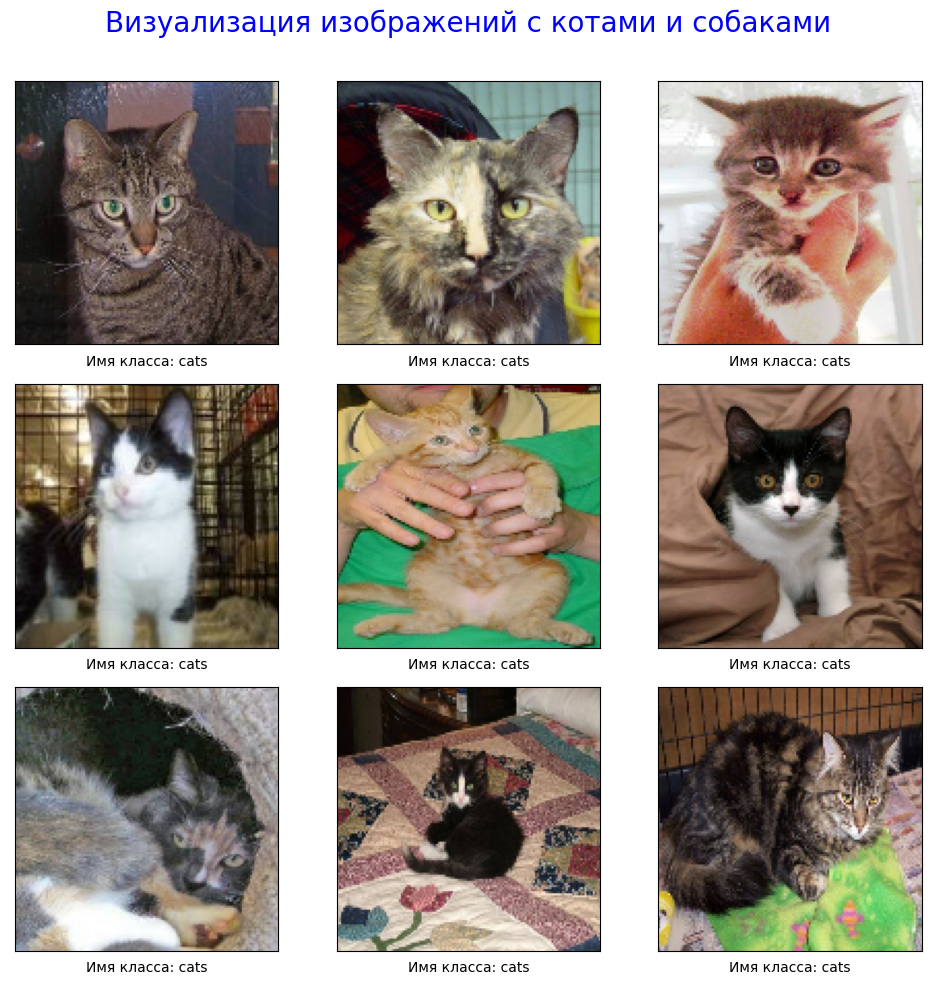

In [ ]:
RandomImage_visualization(class_name,train_image,Y_train)

### Классическое машинное обучение

Я взял несколько моделей для сравнения и занес их конечные метрики в единую сводную таблицу.

Для того, чтобы модели съели данные, надо изменить размерность данных. Сейчас у данные в 4-мерном формате: (количество объектов, количество точек по горизонтали, количество точек по вертикали, количество цветов). Данные необходимо изменить до 2-мерного формата (количество объектов, количество точек) с помощью конкатинации конъюнкции всех описательных параметров одного объекта.

In [ ]:
re_X_train = []
for img in X_train:
    re_X_train.append(img.reshape(-1))
re_X_train = np.asarray(re_X_train)

In [ ]:
re_X_test = []
for img in X_test:
    re_X_test.append(img.reshape(-1))
re_X_test = np.asarray(re_X_test)

In [ ]:
re_X_train.shape

(8000, 49152)

Формируем пустую сводную таблицу, чтобы потом заполнить ее значениями

In [ ]:
scores = pd.DataFrame(
    columns=['accuracy', 'precision', 'recall', 'f1_score', 'duration'],
    index=[
        'LogisticRegression',
        'SVC linear',
        'SVC gauss',
        'KNeighborsClassifier',
        'MLP',
        'DecisionTree',
        'RandomForest',
        'GradientBoosting',
        'GaussianNB'
    ]
)

Функция для получения метрик качества моделей

In [ ]:
from sklearn import metrics

def get_metrics(y_test, y_pred):
    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    precision_score = metrics.precision_score(y_test, y_pred)
    recall_score = metrics.recall_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    return pd.Series(
        (accuracy_score, precision_score, recall_score, f1_score),
        index=['accuracy', 'precision', 'recall', 'f1_score']
    )

Accuracy (точность) - это метрика, которая показывает, как много примеров из тестовой выборки были предсказаны верно. Accuracy определяется как отношение числа правильно классифицированных примеров к общему числу примеров.

$$Accuracy=\frac{TP+TN}{TP+TN+FP+FN}$$

Precision - это метрика качества модели, которая показывает, как часто модель правильно классифицирует положительные примеры. Она определяется как отношение числа верно классифицированных положительных примеров к числу всех примеров, классифицированных как положительные.

$$Precision=\frac{TP}{TP+FP}$$

Recall (полнота) - это метрика, которая оценивает способность модели находить все положительные образцы в наборе данных. Она измеряет, как много релевантных образцов было найдено моделью из общего числа релевантных образцов в наборе данных.

$$Recall=\frac{TP}{TP+FN}$$

F1 score — это среднее гармоническое precision и recall. Это метрика, которая показывает баланс между precision и recall и является хорошим индикатором для оценки качества модели.

F1 score дает более точную информацию о качестве модели, чем accuracy, если в данных присутствует дисбаланс классов. Если, например, один класс присутствует в данных гораздо чаще, чем другой класс, то accuracy может быть высокой, даже если модель классифицирует хуже для редкого класса. В такой ситуации более информативными могут быть precision, recall и F1 score.

F1 score принимает значения в диапазоне от 0 до 1, где 1 — это идеальное значение, которое означает, что модель работает наилучшим образом, а 0 — это худшее значение, которое означает, что модель не предсказывает ни один из классов.

$$F1 score = \frac{2*Precision*Recall}{Precision+Recall}$$

Функция обучения и записи времени процесса обучения модели в секундах

In [ ]:
import time
from sklearn import metrics
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

def model_and_metrics(model):

    # начало обучения модели
    start = time.time()
    model.fit(re_X_train, Y_train)
    Y_pred = model.predict(re_X_test)
    # конец обучения модели
    end = time.time()

    # Построение графика precision_recall
    plot_precision_recall_curve(model, re_X_train, Y_train)
    # Построение графика roc_curve
    plot_roc_curve(model, re_X_train, Y_train)
    # Отображение графика
    plt.show()

    duration = pd.Series([end - start])
    returned = pd.concat([get_metrics(Y_test, Y_pred), duration])
    return returned

График precision-recall curve (кривая точности-полноты) используется для оценки качества бинарной классификации. Он показывает зависимость точности (precision) от полноты (recall) при изменении порога классификации.

Кривая precision-recall представляет собой кривую, проходящую через точки, где каждая точка соответствует определенному значению порога классификации. Чем ближе точка к верхнему правому углу графика, тем выше качество классификатора. Также на графике может быть отмечен порог классификации, при котором достигается наилучшее качество.

ROC-кривая (Receiver Operating Characteristic curve) - это график, который показывает качество бинарной классификации на разных уровнях порога (threshold). Он отображает отношение между положительными верно классифицированными объектами (true positive rate, TPR) и ложными положительными решениями (false positive rate, FPR).

FPR - это доля неправильно классифицированных отрицательных примеров (то есть, количество ложных положительных ответов относительно общего количества отрицательных примеров). TPR - это доля правильно классифицированных положительных примеров (то есть, количество правильно положительных ответов относительно общего количества положительных примеров).

ROC-кривая представляет собой кривую, проходящую через точки с координатами (FPR, TPR) при различных уровнях порога. Она может быть использована для определения наилучшего порога для модели, который максимизирует TPR и минимизирует FPR.

ROC-кривая может быть оценена с помощью метрики AUC-ROC (Area Under the ROC Curve), которая представляет собой площадь, ограниченную ROC-кривой и осью y=x. Значение AUC-ROC может быть интерпретировано как вероятность того, что модель правильно укажет, какой из двух объектов (положительный или отрицательный) имеет более высокую вероятность.

### #1 Classic model (LogisticRegression)

Logistic Regression - это алгоритм машинного обучения, который используется для решения задач классификации, т.е. для разделения данных на категории или классы.

Логистическая регрессия основывается на функции логистической сигмоиды, которая преобразует линейный входной сигнал в вероятность. То есть, логистическая регрессия представляет собой обучение модели, которая использует линейную комбинацию входных признаков для прогнозирования вероятности отнесения объекта к одному из двух классов.

Модель логистической регрессии обучается с помощью метода максимального правдоподобия, который позволяет найти наилучшие значения параметров модели, максимизирующие вероятность наблюдаемых данных.

В логистической регрессии используется также регуляризация, которая помогает бороться с переобучением модели.

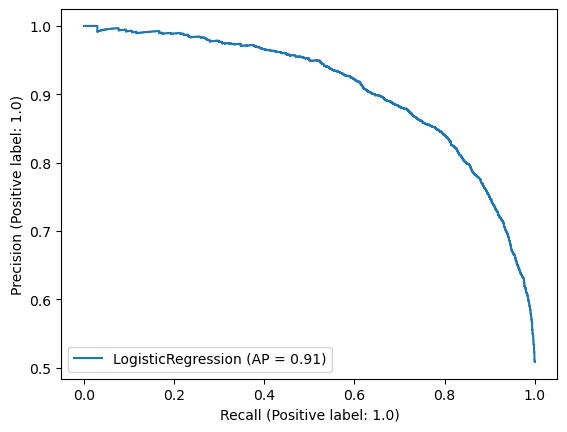

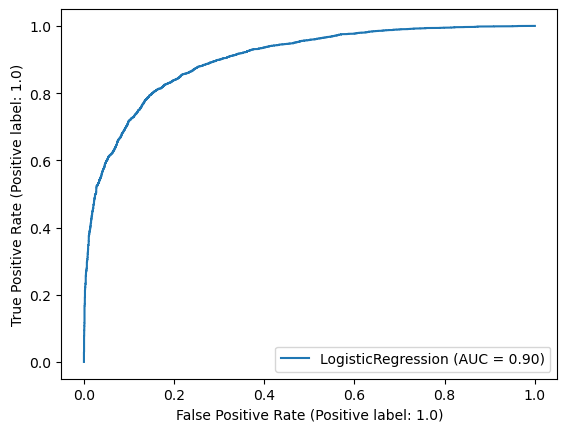

In [ ]:
from sklearn.linear_model import LogisticRegression

scores.iloc[0] = model_and_metrics(LogisticRegression()) #max_iter=1000

### #2 Classic model (SVM.linear)

SVM - это метод машинного обучения, который использует гиперплоскость для разделения классов в многомерном пространстве. Линейное ядро в SVM представляет собой обычную линейную функцию, которая стремится разделить классы на две группы с помощью гиперплоскости в пространстве признаков.

Модель svm.SVC(kernel='linear') подходит для задач классификации с двумя классами и может использоваться для разделения данных с линейно разделимыми классами. Обучение модели происходит путем поиска гиперплоскости, которая разделяет классы наиболее точно. SVM поддерживает не только линейные ядра, но также может использовать ядра с нелинейными функциями, такие как полиномиальные и радиально-базисные функции.

Для обучения модели SVM c линейным ядром используется метод оптимизации под названием Sequential Minimal Optimization (SMO), который является быстрым и эффективным методом для решения оптимизационной задачи SVM.

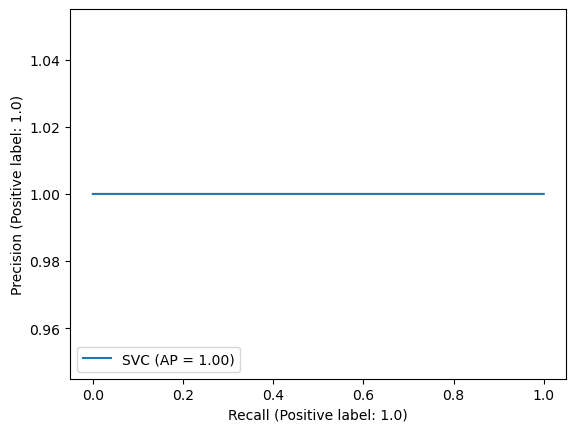

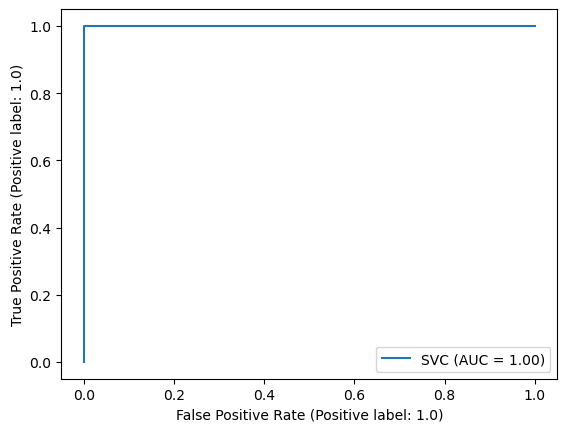

In [ ]:
from sklearn import svm

scores.iloc[1] = model_and_metrics(svm.SVC(kernel='linear'))

### #3 Classic model (SVM.rbf)

RBF-ядро является одним из наиболее популярных ядер, используемых в SVM для обработки нелинейных данных.

Суть работы алгоритма SVM с ядром RBF заключается в следующем:

- Выбрать оптимальные параметры ядра RBF.
- Обучить классификатор SVM на обучающих данных.
- Применить обученный классификатор SVM к новым данным для классификации.

Классификатор SVM с ядром RBF является более гибким по сравнению с классификатором SVM с линейным ядром, так как позволяет лучше разделить нелинейные данные. Однако, он имеет больше параметров, которые нужно настроить для достижения лучшей производительности модели. Также, в отличие от линейного ядра, классификатор с RBF-ядром склонен к переобучению на небольших выборках данных.

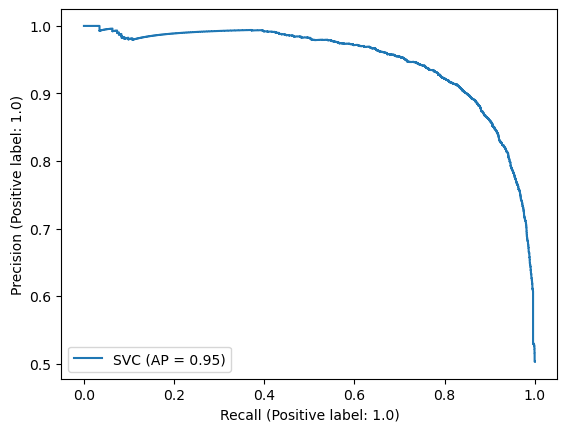

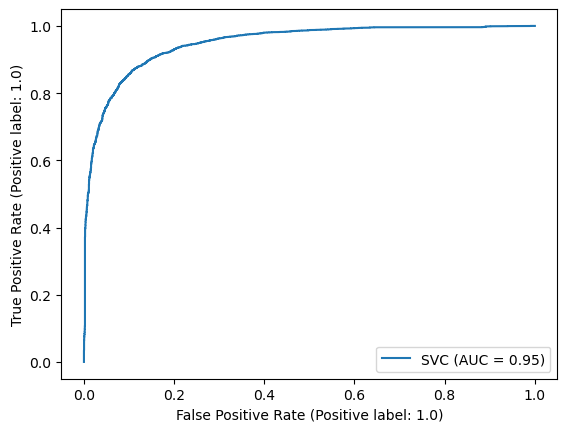

In [ ]:
from sklearn import svm

scores.iloc[2] = model_and_metrics(svm.SVC(kernel='rbf'))

### #4 Classic model (KNeighborsClassifier)

KNeighborsClassifier - это алгоритм классификации, который основывается на определении класса объекта путем анализа классов его ближайших соседей в пространстве признаков.

В данном алгоритме объекты сравниваются на основе расстояния между ними в пространстве признаков. Определяется k ближайших соседей для каждого объекта, после чего класс объекта определяется на основе классов его соседей. Обычно для вычисления расстояний между объектами используется евклидово расстояние, однако возможно использование и других метрик.

Количество соседей k - это один из гиперпараметров модели, который определяется заранее. Если k=1, то классификация объекта производится на основе класса его ближайшего соседа. Если k>1, то классификация производится путем голосования за наиболее часто встречающийся класс среди k ближайших соседей.

Кроме того, для работы модели необходимо выбрать метрику расстояния и метод взвешивания расстояний.

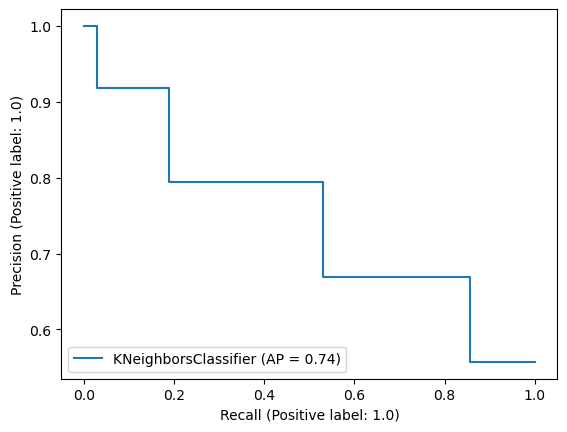

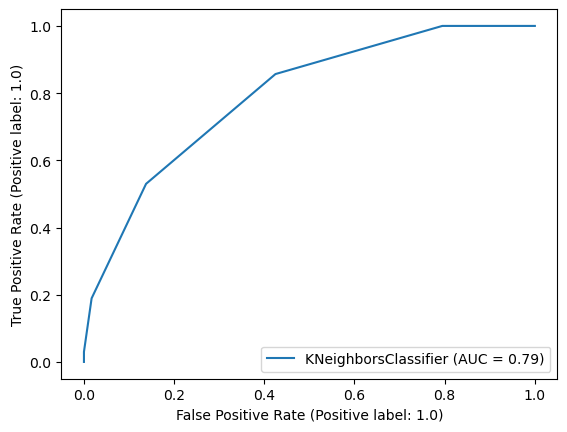

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

scores.iloc[3] = model_and_metrics(KNeighborsClassifier())

### #5 Classic model (MLPClassifier)

MLPClassifier - это алгоритм машинного обучения, который относится к семейству нейронных сетей. Он использует многослойную перцептронную модель, которая состоит из нескольких скрытых слоев, каждый из которых содержит набор нейронов. MLPClassifier используется для задач классификации, то есть он пытается определить, к какому классу относится входной образец данных.

Основная идея MLPClassifier заключается в том, чтобы обучать модель путем подачи обучающих примеров на вход нейронной сети и последующей корректировки весов между нейронами. Это происходит через процесс обратного распространения ошибки (backpropagation), в котором модель сначала делает предсказание, затем оценивает, насколько оно верно, и корректирует веса, чтобы улучшить предсказания на следующей итерации.

MLPClassifier позволяет настраивать множество параметров, включая количество скрытых слоев, количество нейронов в каждом слое, тип функции активации, метод оптимизации и т.д. Одним из главных параметров MLPClassifier является alpha, который контролирует уровень регуляризации. Большие значения alpha могут привести к уменьшению переобучения модели, но также могут снизить ее общую точность.

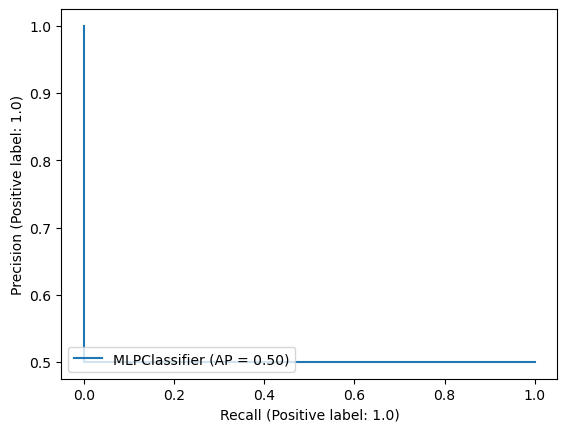

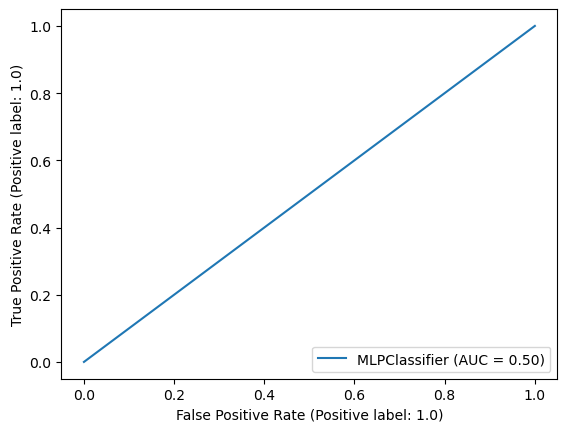

In [ ]:
from sklearn.neural_network import MLPClassifier

scores.iloc[4] = model_and_metrics(MLPClassifier())

### #6 Classic model (DecisionTree)

DecisionTree (Дерево решений) - это один из наиболее популярных методов машинного обучения для задач классификации и регрессии. Он является примером обучения с учителем и используется для построения модели прогнозирования на основе множества правил.

Принцип работы алгоритма заключается в разбиении исходного набора данных на более мелкие поднаборы, путем построения древовидной структуры, где каждый узел дерева представляет собой условие на одном из признаков, а каждое ребро - возможный результат теста. Древо строится снизу вверх, начиная с корневого узла, где разбиение основано на наиболее значимом признаке, и продолжается до тех пор, пока не будет достигнут критерий остановки, например, достижение максимальной глубины или минимального количества объектов в листе.

После построения дерева, каждый объект классифицируется путем прохождения по нему, начиная с корневого узла и двигаясь вниз по ребрам до достижения листового узла. Классификация происходит на основе меток классов в листовом узле.

Одним из преимуществ DecisionTree является его интерпретируемость, что означает возможность легкого понимания результата, полученного моделью. Также DecisionTree устойчив к выбросам и нечувствителен к масштабированию признаков.

Однако, как и у любой модели машинного обучения, есть и недостатки. DecisionTree склонен к переобучению на больших датасетах и может давать плохие результаты на данных, которые не были представлены во время обучения модели.

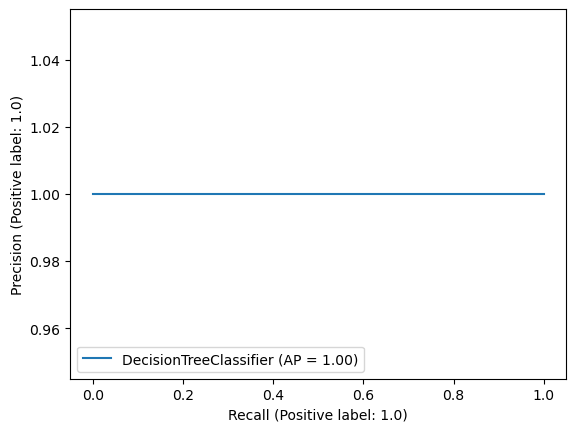

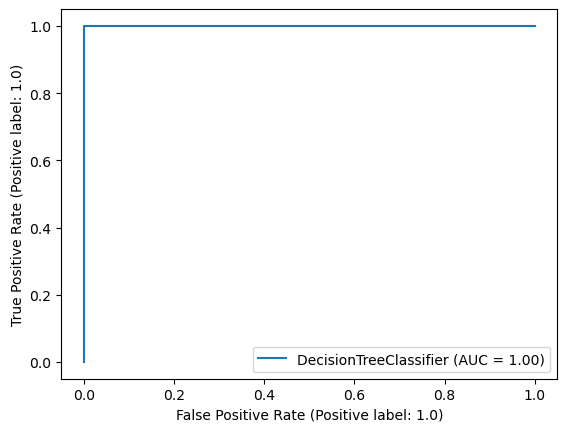

In [ ]:
from sklearn.tree import DecisionTreeClassifier

scores.iloc[5] = model_and_metrics(DecisionTreeClassifier())

### #7 Classic model (RandomForest)

Random Forest (случайный лес) - это алгоритм машинного обучения, который использует ансамбль решающих деревьев для решения задач классификации, регрессии и кластеризации. Он является одним из наиболее популярных алгоритмов машинного обучения и широко используется в различных областях, включая банкинг, финансы, медицину, науку о данных и другие.

Случайный лес состоит из множества решающих деревьев, каждое из которых строится на основе случайной подвыборки данных. Это позволяет уменьшить вероятность переобучения и повысить качество предсказаний. Кроме того, случайный лес позволяет оценить важность признаков, что может быть полезно при анализе данных.

Для построения случайного леса сначала выбирается количество деревьев, которые должны быть включены в ансамбль. Затем для каждого дерева выбирается случайная подвыборка данных и случайный поднабор признаков. Затем строится дерево решений, которое оптимизируется на основе выбранного критерия (например, энтропии или Джини). Критерий оценивает, насколько хорошо каждый признак разделяет данные на классы или прогнозирует значение.

После построения всех деревьев случайный лес может использоваться для предсказания новых данных. Для каждого дерева происходит предсказание, затем выбирается наиболее часто встречающийся класс или среднее значение, и это становится итоговым предсказанием.

Случайный лес имеет несколько преимуществ по сравнению с одним решающим деревом, включая более точные предсказания и устойчивость к шумам в данных. Кроме того, случайный лес хорошо работает с большими объемами данных и может обрабатывать как числовые, так и категориальные признаки.

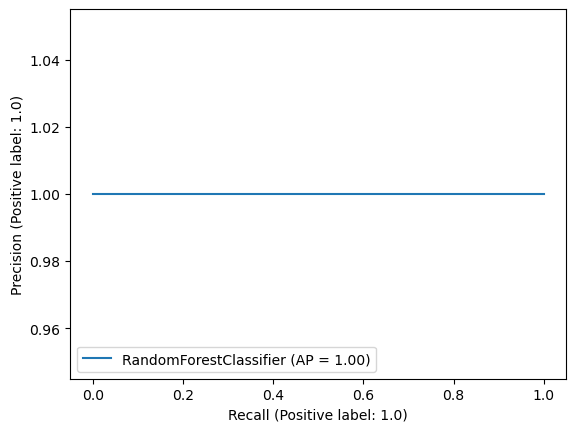

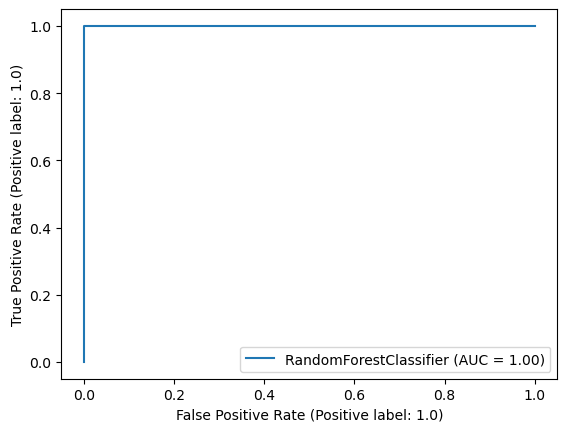

In [ ]:
from sklearn.ensemble import RandomForestClassifier

scores.iloc[6] = model_and_metrics(RandomForestClassifier())

### #8 Classic model (GradientBoosting)

Gradient Boosting (GB) - это метод машинного обучения, который основан на построении ансамбля (ensemble) слабых моделей, как правило, деревьев решений. Основная идея GB заключается в том, чтобы последовательно строить новые модели, которые будут исправлять ошибки предыдущих моделей. Таким образом, каждая новая модель учитывает ошибки предыдущих моделей, и все модели образуют сильную модель.

Алгоритм GB работает следующим образом:

Сначала мы создаем модель, которая делает предсказания на основе среднего значения целевой переменной в тренировочных данных.

Затем мы строим следующую модель, используя реальные значения целевой переменной и ошибки предыдущей модели.

Новая модель старается исправить ошибки предыдущей модели.

Мы продолжаем строить новые модели и добавлять их к ансамблю до тех пор, пока не достигнем установленного числа деревьев.

Основными параметрами GB являются:

learning rate (шаг обучения), который определяет величину обновления весов на каждой итерации.

число деревьев (n_estimators), которые будут использоваться для построения ансамбля.

максимальная глубина дерева (max_depth), которая определяет глубину дерева решений.

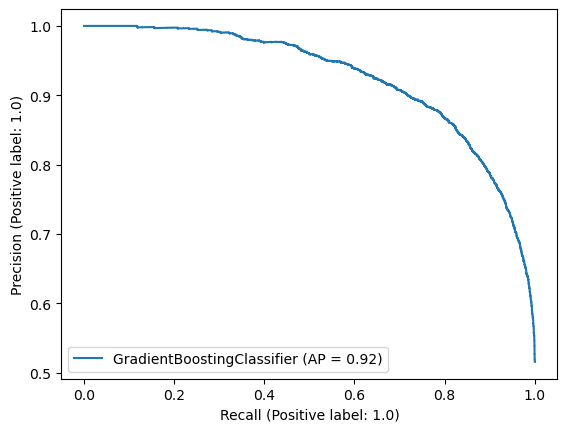

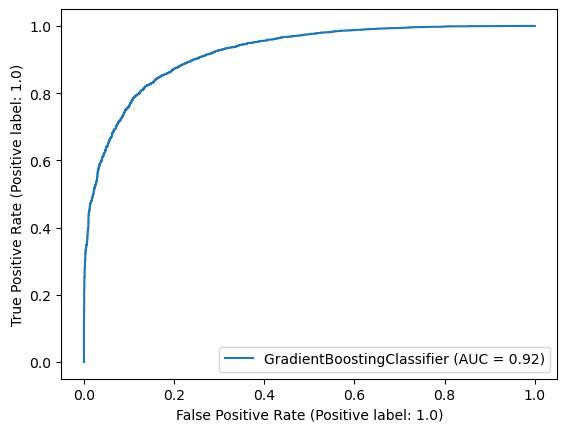

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

scores.iloc[7] = model_and_metrics(GradientBoostingClassifier())

### #9 Classic model (GaussianNB)

Gaussian Naive Bayes (GNB) - это вероятностный алгоритм классификации, основанный на теореме Байеса и условии независимости. Этот алгоритм предполагает, что значения каждого признака в каждом классе имеют гауссово распределение. GNB использует эти распределения, чтобы оценить вероятность того, что объект принадлежит к определенному классу. Затем он выбирает класс с максимальной вероятностью как прогноз.

Главное преимущество GNB заключается в его простоте и скорости работы. Этот алгоритм работает хорошо на наборах данных с множеством признаков, но может давать плохие результаты, если признаки сильно коррелируют между собой. Кроме того, GNB не учитывает взаимодействия между признаками и не может захватывать нелинейные зависимости между признаками и целевой переменной.

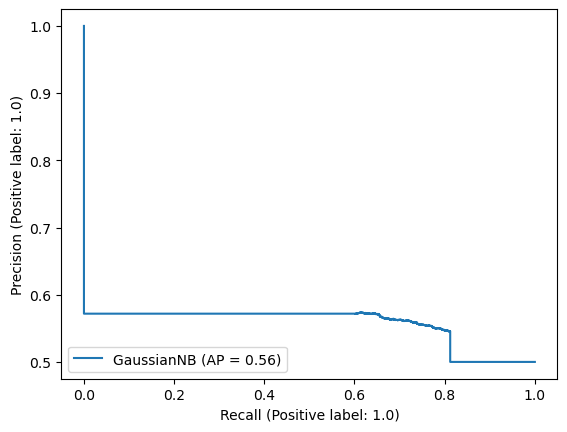

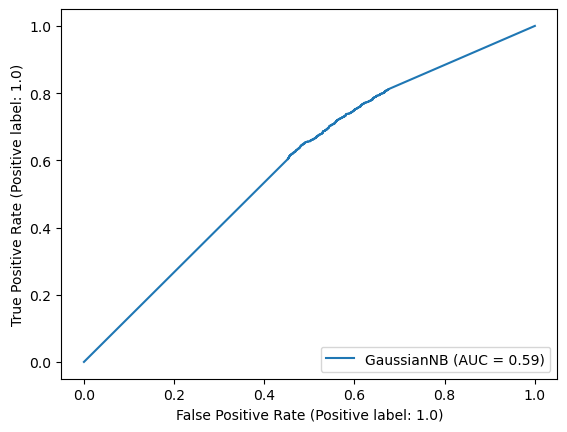

In [ ]:
from sklearn.naive_bayes import GaussianNB

scores.iloc[8] = model_and_metrics(GaussianNB())

### Анализ процесса обучения

Смотрим резултаты сводной таблицы и сравниваем модели по метрикам качества

In [ ]:
scores

accuracy precision recall  f1_score      duration
LogisticRegression     0.5855  0.583906  0.595  0.589401      21.32518
SVC linear              0.565  0.568134  0.542  0.554759   1205.185594
SVC gauss              0.6695  0.672783   0.66   0.66633   1899.521997
KNeighborsClassifier   0.5455  0.581395  0.325  0.416934     16.880603
MLP                       0.5       0.5    1.0  0.666667     96.398467
DecisionTree            0.541  0.542531  0.523  0.532587    576.256765
RandomForest            0.645  0.660754  0.596  0.626709    160.727693
GradientBoosting        0.657  0.655138  0.663  0.659046  13837.839334
GaussianNB              0.586  0.580827  0.618  0.598837       6.67138

Исходя из таблицы метрик качества, можно сделать следующие выводы:

- Лучшей моделью по метрикам качества является SVC с ядром "gauss" (accuracy=0.6695, precision=0.672783, recall=0.66, f1_score=0.66633), так как она имеет самую высокую точность и f1-score.

- Лучшей моделью по затраченному времени является LogisticRegression (duration=22.277857), так как она имеет самое быстрое время обучения.

- Оптимальной моделью можно считать SVC с ядром "gauss", так как она имеет хорошие показатели метрик качества и не является слишком медленной.

Таким образом, наилучшей моделью для данной задачи можно считать SVC с ядром "gauss".

## Нейронные сети

### #1 Neural model (CNN)

Для примера модели классификации мы будем использовать наиболее распространенную модель Сверточной нейронной сети. В нее можно включить большое число слоев, но чаще всего строится 3 слоя, так мы и поступим

CNN (Convolutional Neural Network) - это класс нейронных сетей, разработанных для обработки данных с несколькими измерениями, такими как изображения.

Основной идеей CNN является использование свертки (convolution) в качестве основного оператора для извлечения признаков из входных данных. Этот процесс сравнивает небольшие участки входных данных с фильтрами (kernels) свертки, чтобы создать карту признаков (feature map). Затем, используя операцию субдискретизации (subsampling) или пулинга (pooling), размерность карты признаков уменьшается, сохраняя при этом наиболее важные признаки.

CNN обычно состоит из трех типов слоев: сверточные (convolutional), слои субдискретизации (subsampling) или пулинга (pooling), а также полносвязные (fully-connected) слои. Сверточные слои извлекают признаки из входных данных, слои субдискретизации снижают размерность карты признаков, а полносвязные слои преобразуют карту признаков в выходные данные.

CNN успешно используется для классификации изображений, распознавания образов, распознавания речи, обработки естественного языка и других задач машинного обучения.

Create Custom CNN Model

In [ ]:
model = Sequential([

    # Input Layer

    Conv2D(32, (3, 3), activation = "relu", input_shape = (128, 128, 3)),
    MaxPooling2D(2, 2),

    #1st Hidden Layer

    Conv2D(64, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),

     #2nd Hidden Layer

    Conv2D(128, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),
    #3rd Hidden Layer

    Conv2D(256, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),

    Flatten(),

    # Connected Layer

    Dense(256, activation = "relu"),
    Dense(2, activation = "softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [ ]:
model.compile(optimizer = 'adam',loss = "sparse_categorical_crossentropy",metrics = ['accuracy'])

In [ ]:
history=model.fit(train_image,Y_train,validation_data=(test_image,Y_test),batch_size=42,epochs=20)

Epoch 1/20
191/191 [==============================] - 41s 204ms/step - loss: 0.6915 - accuracy: 0.5316 - val_loss: 0.6926 - val_accuracy: 0.5170
Epoch 2/20
191/191 [==============================] - 38s 200ms/step - loss: 0.6440 - accuracy: 0.6274 - val_loss: 0.6200 - val_accuracy: 0.6535
Epoch 3/20
191/191 [==============================] - 39s 205ms/step - loss: 0.5473 - accuracy: 0.7244 - val_loss: 0.5036 - val_accuracy: 0.7610
Epoch 4/20
191/191 [==============================] - 39s 204ms/step - loss: 0.4729 - accuracy: 0.7694 - val_loss: 0.4651 - val_accuracy: 0.7890
Epoch 5/20
191/191 [==============================] - 38s 200ms/step - loss: 0.4075 - accuracy: 0.8114 - val_loss: 0.4747 - val_accuracy: 0.7815
Epoch 6/20
191/191 [==============================] - 33s 175ms/step - loss: 0.3551 - accuracy: 0.8424 - val_loss: 0.4227 - val_accuracy: 0.8165
Epoch 7/20
191/191 [==============================] - 32s 168ms/step - loss: 0.2987 - accuracy: 0.8666 - val_loss: 0.4459 - val_ac

### График потерь при обучении модели и точности

In [ ]:
def model_loss_and_accuracy(history):

    fig=plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.plot(history.history["accuracy"],"bo--",label="accuracy")
    plt.plot(history.history["val_accuracy"],"ro--",label="val_accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend(loc="upper left")
    plt.tight_layout()


    plt.subplot(222)
    plt.plot(history.history["loss"],"bo--",label="loss")
    plt.plot(history.history["val_loss"],"ro--",label="val_loss")
    plt.title("Model Loss")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

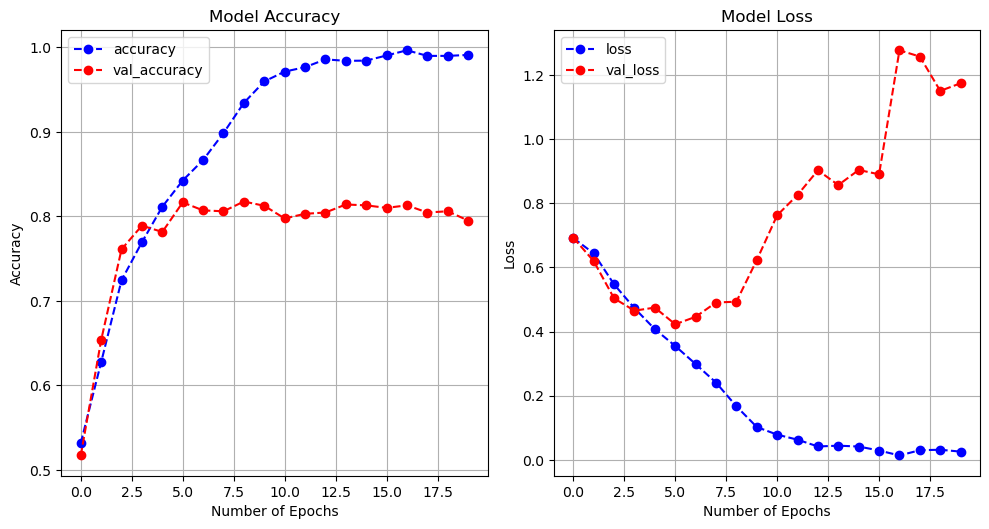

In [ ]:
 model_loss_and_accuracy(history)

In [ ]:
model.evaluate(test_image,Y_test)

63/63 [==============================] - 2s 38ms/step - loss: 1.1744 - accuracy: 0.7950


[1.1744052171707153, 0.7950000166893005]

### Матрица ошибок (Confusion Matrix)

Матрица ошибок, также известная как матрица неточностей или матрица оценки, является инструментом визуализации, который используется для оценки качества модели машинного обучения. Она позволяет легко понять, насколько хорошо модель предсказывает метки классов на тестовых данных.

Матрица ошибок представляет собой квадратную матрицу, в которой каждая строка представляет фактическую метку класса, а каждый столбец - предсказанную метку класса. Значения на диагонали представляют собой количество правильных предсказаний, а значения за пределами диагонали - количество неправильных предсказаний.

Пример матрицы ошибок для бинарной классификации (два класса: "положительный" и "отрицательный"):

|          | Предсказанный "Положительный" | Предсказанный "Отрицательный" |
|----------|----------|----------|
| Фактически "Положительный"    | True Positive (TP)   | False Negative (FN)   |
| Фактически "Отрицательный"    | False Positive (FP)   | True Negative (TN)   |

Таким образом, TP - это количество истинных положительных результатов, FN - количество ложных отрицательных результатов, FP - количество ложных положительных результатов и TN - количество истинных отрицательных результатов.

Матрица ошибок может быть использована для вычисления различных метрик, таких как точность, полнота и F1-мера. Она также может быть использована для оценки качества модели на разных классах и для определения, на каких классах модель делает наибольшее количество ошибок.

In [ ]:
from sklearn.metrics import confusion_matrix

63/63 [==============================] - 3s 38ms/step


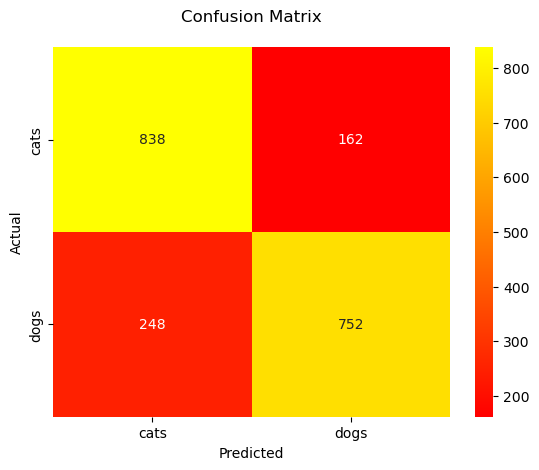

In [ ]:
# Получаем предсказания на тестовых данных
prediction = model.predict(test_image)

# Получаем метки классов из предсказаний
prediction_label = np.argmax(prediction, axis=1)

# Вычисляем матрицу ошибок
cm = confusion_matrix(Y_test, prediction_label)

# Строим тепловую карту с помощью библиотеки seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="autumn", xticklabels=class_name, yticklabels=class_name)

# Добавляем название графика и осей
plt.title("Confusion Matrix\n")
plt.ylabel("Actual")
plt.xlabel("Predicted")

# Отображаем график
plt.show()

### Отчет о классификации

"classification_report" - это функция из библиотеки sklearn.metrics и используется для вывода отчета о метриках качества модели машинного обучения для задачи классификации. Он включает в себя метрики, такие как точность (precision), полноту (recall), F1-меру (F1-score) и др.

Функция принимает два аргумента: y_true(y_test) (реальные метки) и y_pred (предсказанные метки), а также несколько дополнительных параметров. Она возвращает строку, содержащую отчет о метриках качества модели.

In [ ]:
print(classification_report(Y_test,prediction_label,target_names=["Cats","Dogs"]))

              precision    recall  f1-score   support

        Cats       0.77      0.84      0.80      1000
        Dogs       0.82      0.75      0.79      1000

    accuracy                           0.80      2000
   macro avg       0.80      0.79      0.79      2000
weighted avg       0.80      0.80      0.79      2000



### Неверное предсказание модели

In [ ]:
def incorrect_Image_visualization(class_names,imagedata_path,imagedata_label):
    # Создание фигуры для визуализации
    fig=plt.figure(figsize=(10,10))
    # Добавление заголовка
    fig.suptitle("Incorrect  Images Visualization\n",color="blue",fontsize=20)

    for i in range(9):
        # Добавление подграфика
        plt.subplot(3,3,i+1)
        # Отключение подписей для осей x и y
        plt.xticks([])
        plt.yticks([])
        # Размещение графиков сжато друг к другу
        plt.tight_layout()
        # Вывод изображения на подграфике
        plt.imshow(imagedata_path[i],cmap=plt.cm.BrBG)
        # Добавление подписи с именем класса для изображения
        plt.xlabel("Class Names: {}".format(class_names[int(imagedata_label[i])]))
    # Отображение фигуры
    plt.show()

In [ ]:
def model_prediction(class_name,imagedata,imagelabel,predict_label):
    # Получаем результаты предсказаний и индексы неправильных предсказаний
    result = (imagelabel == predict_label)
    incorrect_result = np.where(result == 0)
    incorrect_result = np.asarray(incorrect_result)
    incorrect_result = incorrect_result.flatten()

    false_image = []   # Список для хранения неправильных изображений
    false_label = []   # Список для хранения предсказанных меток

    # Заполняем списки неправильных изображений и предсказанных меток
    for b in incorrect_result:
        false_image.append(imagedata[b])
        false_label.append(predict_label[b])

    # Визуализируем неправильные предсказания
    print("Неправильные предсказания модели:\n")
    incorrect_Image_visualization(class_name, false_image, false_label)

Неправильные предсказания модели:



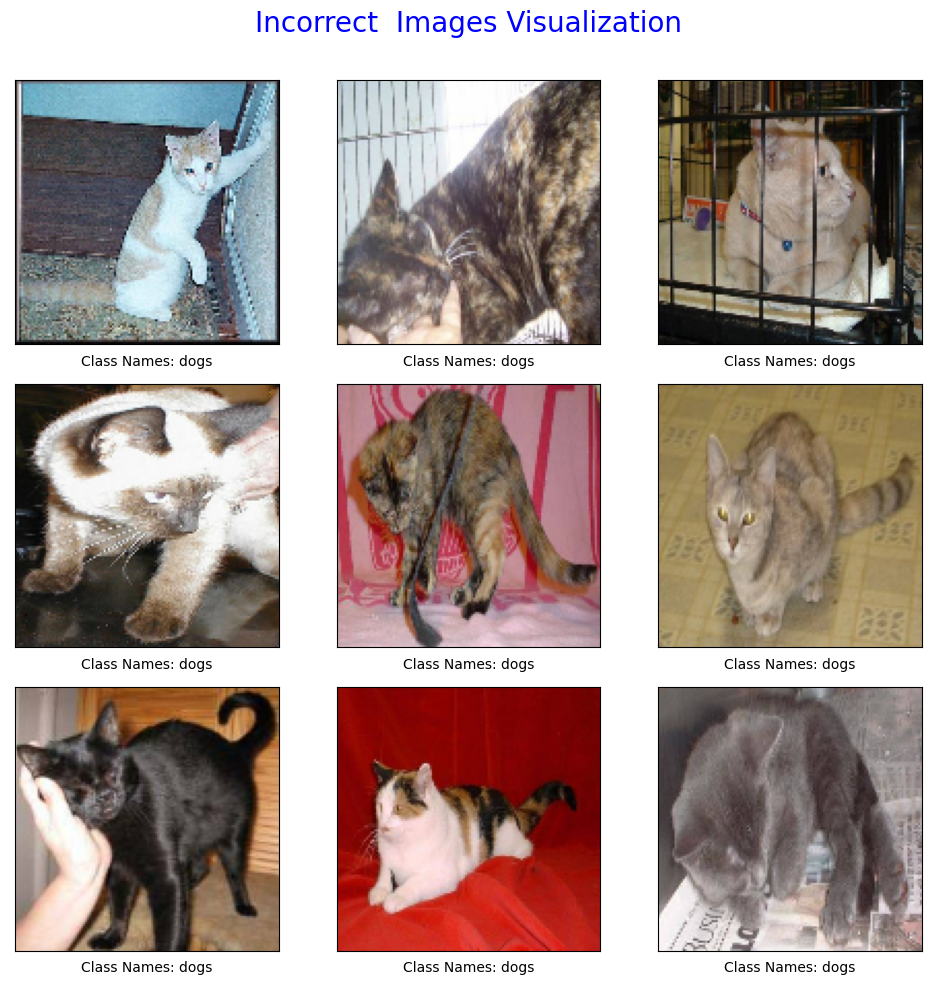

In [ ]:
model_prediction(class_name,test_image,Y_test,prediction_label)

###  Предсказание данных

1/1 [==============================] - 0s 124ms/step
cat


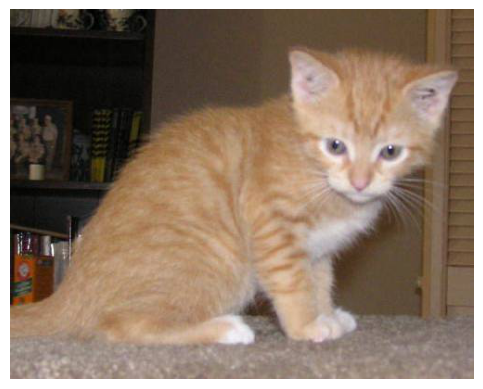

In [ ]:
# Создаем словарь с двумя ключами 0 и 1, соответствующими классам 'cat' и 'dog' соответственно
results={0:'cat',    1:'dog'}

# Загружаем тестовое изображение кота
test_image_path=Image.open("./dataset/test_set/cats/cat.4003.jpg")

#Меняем размер изображения до указанного значения (image_shape)
imge=test_image_path.resize(image_shape)

# Добавляем новую размерность в массив изображений, чтобы соответствовать входным данным модели
imge=np.expand_dims(imge,axis=0)

# Нормализуем значения пикселей изображения от 0 до 1
imge=np.array(imge)/255

# Предсказываем класс изображения с помощью модели
final_predct=np.argmax(model.predict([imge])[0])


# Выводим результат предсказания, используя словарь results и индекс, полученный из модели
print(results[final_predct])

# Отображаем тестовое изображение
plt.imshow(test_image_path)

# Убираем оси координат изображения
plt.axis("off")

# Отображаем изображение
plt.show()

### #2 Neural model (MLP)

Теперь можно сравнить полученные резултаты с еще одном типом нейронной сети - Многослойный персептрон. Эта модель является однослойной в отличии от Сверточной, у которой в нашем случае было 3 скрытых слоя.

MLP (Multilayer Perceptron) - это нейронная сеть прямого распространения, состоящая из одного или нескольких полносвязных слоев. В MLP каждый нейрон в слое связан со всеми нейронами предыдущего и следующего слоя. Входные данные проходят через сеть и взвешенная сумма входных сигналов каждого нейрона проходит через функцию активации, что приводит к выходу из сети. MLP часто используется для задач классификации и регрессии.

Архитектура MLP может быть очень разной и зависит от конкретной задачи. Обычно она состоит из одного или нескольких скрытых слоев с нейронами и одного выходного слоя. Количество нейронов в скрытом слое может быть выбрано эмпирически или определено при помощи методов кросс-валидации. Оптимизация весов в MLP обычно осуществляется методом обратного распространения ошибки (backpropagation).

MLP имеет несколько преимуществ по сравнению с другими типами нейронных сетей, так как он легко обучается, его можно применять к широкому спектру задач, он не требует больших вычислительных ресурсов для обучения и может обрабатывать данные с различными типами признаков. Однако он имеет некоторые недостатки, например, он неэффективен для обработки изображений и других типов данных с большим количеством признаков, и он не может обрабатывать последовательности данных, такие как тексты или временные ряды.

Create Custom MLP Model

In [ ]:
model = Sequential([
    # Input Layer
    Dense(128, activation='relu', input_shape=(128, 128, 3,)),

    # Hidden Layers
    Dense(128, activation='relu'),

    # Output Layer
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_image, Y_train, validation_data=(test_image, Y_test), batch_size=42, epochs=20)


Epoch 1/20
191/191 [==============================] - 84s 437ms/step - loss: 0.7555 - accuracy: 0.6270 - val_loss: 0.6286 - val_accuracy: 0.6480
Epoch 2/20
191/191 [==============================] - 83s 433ms/step - loss: 0.6220 - accuracy: 0.6500 - val_loss: 0.6164 - val_accuracy: 0.6715
Epoch 3/20
191/191 [==============================] - 82s 430ms/step - loss: 0.6031 - accuracy: 0.6766 - val_loss: 0.6165 - val_accuracy: 0.6710
Epoch 4/20
191/191 [==============================] - 86s 448ms/step - loss: 0.5793 - accuracy: 0.6961 - val_loss: 0.6252 - val_accuracy: 0.6575
Epoch 5/20
191/191 [==============================] - 89s 466ms/step - loss: 0.5531 - accuracy: 0.7115 - val_loss: 0.6388 - val_accuracy: 0.6500
Epoch 6/20
191/191 [==============================] - 88s 462ms/step - loss: 0.5304 - accuracy: 0.7303 - val_loss: 0.6441 - val_accuracy: 0.6525
Epoch 7/20
191/191 [==============================] - 85s 446ms/step - loss: 0.4999 - accuracy: 0.7535 - val_loss: 0.6664 - val_ac

In [ ]:
def model_loss_and_accuracy(history):

    fig=plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.plot(history.history["accuracy"],"bo--",label="accuracy")
    plt.plot(history.history["val_accuracy"],"ro--",label="val_accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend(loc="upper left")
    plt.tight_layout()


    plt.subplot(222)
    plt.plot(history.history["loss"],"bo--",label="loss")
    plt.plot(history.history["val_loss"],"ro--",label="val_loss")
    plt.title("Model Loss")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

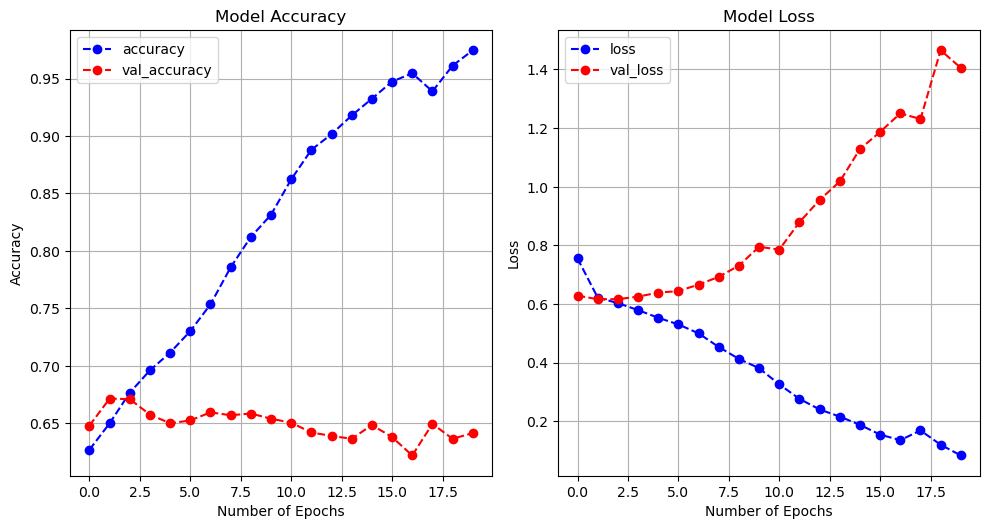

In [ ]:
 model_loss_and_accuracy(history)

In [ ]:
model.evaluate(test_image,Y_test)

63/63 [==============================] - 8s 120ms/step - loss: 1.4055 - accuracy: 0.6415


[1.4054920673370361, 0.6414999961853027]

### Confusion Matrix

63/63 [==============================] - 8s 121ms/step


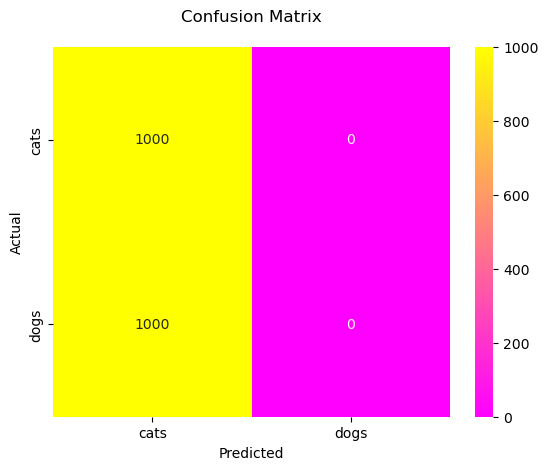

In [ ]:
# Получаем предсказания на тестовых данных
prediction = model.predict(test_image)

# Получаем метки классов из предсказаний
prediction_label = np.argmax(prediction, axis=1)

# Вычисляем матрицу ошибок
cm = confusion_matrix(Y_test, prediction_label)

# Строим тепловую карту с помощью библиотеки seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="spring", xticklabels=class_name, yticklabels=class_name)

# Добавляем название графика и осей
plt.title("Confusion Matrix\n")
plt.ylabel("Actual")
plt.xlabel("Predicted")

# Отображаем график
plt.show()

### Classification Report

In [ ]:
print(classification_report(Y_test,prediction_label,target_names=["Cats","Dogs"]))

              precision    recall  f1-score   support

        Cats       0.50      1.00      0.67      1000
        Dogs       0.00      0.00      0.00      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



# Вывод

Классические модели обучения и нейронные сети имеют свои преимущества и недостатки, и выбор определенной модели зависит от многих факторов, таких как задача, данные, вычислительные ресурсы, опыт разработчика и т.д.

Классические модели обучения, такие как логистическая регрессия, решающие деревья, случайный лес, метод опорных векторов и т.д., могут быть эффективными для решения задач с малым количеством данных или небольшим количеством признаков, а также для задач, где интерпретируемость модели является важным фактором. Классические модели могут быть более легкими в обучении и требовать меньшего количества вычислительных ресурсов, чем нейронные сети.

С другой стороны, нейронные сети могут быть более эффективными для решения задач, где имеется большой объем данных или большое количество признаков. Они могут быть лучшим выбором для задач компьютерного зрения, обработки естественного языка и рекомендательных систем. Нейронные сети могут обнаруживать сложные нелинейные зависимости между признаками и выявлять скрытые паттерны в данных, что делает их особенно полезными для задач, где нет явных правил или определенной структуры данных.

Эта работа еще раз доказывает то, что на больших наборах данных нейронные сети справляются гораздо лучше, чем любая классическая модель обучения. В данном случае CNN показала себя лучше, чем MLP, потому что вторая переобучилась и показывает некорректные значения.